In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



In [2]:
import torch

"""
beta_start and beta_end are hyperparameters
"""
class LinearNoiseScheduler:
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        self.timesteps = timesteps

        # Start and end are the beta values for the linear noise schedule that we linearly interpolate between (hence linear scheduler)
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas # Equation 1
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # Equation 2

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor):
        """
        Forward process: q(x_t | x_0)
        """
        epsilon = torch.randn_like(x0) # Input: x_0 - it returns the same size/shape as the input tensor (i.e. image)

        # gather alpha_bars for each sample in the batch
        alpha_bar_t = self.alpha_hat[t].view(-1, 1, 1, 1).to(x0.device)
        first_term = torch.sqrt(alpha_bar_t) * x0
        second_term = torch.sqrt(1 - alpha_bar_t) * epsilon
        return first_term + second_term, epsilon, first_term, second_term # Equation 3

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.69MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 77.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]


torch.Size([64, 1, 28, 28])
torch.Size([64])


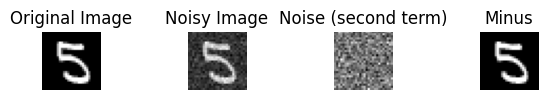

In [ ]:
noise_sched = LinearNoiseScheduler()

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean & std
])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: iterate over the data
for images, labels in train_loader:
    print(images.shape)  # e.g., torch.Size([64, 1, 28, 28])
    print(labels.shape)  # e.g., torch.Size([64])

    image = images[0]
    timestep = 100
    noisy_img, noise, first_term, second_term = noise_sched.add_noise(image, timestep)
    noisy_img = noisy_img.squeeze(0)
    noise = noise.squeeze(0)
    first_term = first_term.squeeze()
    second_term = second_term.squeeze()

    minus = noisy_img - second_term
    minus = minus.squeeze()


    # plot the original and noisy images
    plt.subplot(1, 4, 1)
    plt.imshow(image[0].numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_img[0].numpy(), cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(second_term.numpy(), cmap='gray')
    plt.title('Noise (second term)')
    plt.axis('off')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(minus.numpy(), cmap='gray')
    plt.title('Minus')
    plt.axis('off')

    plt.subplots_adjust(wspace=1.5)  # adjust this value as needed

    plt.show()

    break